# Download Dataset

In [ ]:
# get data
!wget -O ml-latest-small.zip https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

# unzip file
!unzip ml-latest-small.zip

--2025-05-30 04:52:25--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.24MB/s    in 0.3s    

2025-05-30 04:52:26 (3.24 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


# Import Libraries

In [ ]:
!pip install lightfm

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

# Data Understanding

## 📊 Summary of MovieLens Small (Latest Version) Dataset

**Dataset**: [MovieLens Small Latest Dataset on Kaggle](https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset)

---

## 🎬 Struktur File `movies.csv`

| Kolom   | Tipe Data | Deskripsi                                                                 | Contoh                        |
|---------|-----------|---------------------------------------------------------------------------|-------------------------------|
| movieId | Integer   | ID unik untuk setiap film, konsisten di seluruh file (ratings, tags, links, movies). | 1                             |
| title   | String    | Judul film, termasuk tahun rilis dalam tanda kurung.                      | Toy Story (1995)             |
| genres  | String    | Daftar genre film, dipisahkan oleh simbol pipe. | Adventure\|Animation\|Children |

### 🎭 Daftar Genre yang Tersedia:
`Action`, `Adventure`, `Animation`, `Children's`, `Comedy`, `Crime`, `Documentary`, `Drama`, `Fantasy`, `Film-Noir`, `Horror`, `Musical`, `Mystery`, `Romance`, `Sci-Fi`, `Thriller`, `War`, `Western`, `(no genres listed)`

---

## ⭐ Struktur File `ratings.csv`

| Kolom     | Tipe Data | Deskripsi                                                                                     | Contoh     |
|-----------|-----------|-----------------------------------------------------------------------------------------------|------------|
| userId    | Integer   | ID unik dari pengguna yang memberikan rating. Konsisten dengan tags.csv.                      | 10         |
| movieId   | Integer   | ID film yang diberi rating (terhubung ke movies.csv).                                         | 1          |
| rating    | Float     | Nilai rating dari 0.5 hingga 5.0 dalam kelipatan 0.5.                                         | 4.0        |
| timestamp | Integer   | Waktu dalam format Unix timestamp (detik sejak 1 Januari 1970 UTC).                          | 964982703  |

📌 **Catatan**:
- File ini diurut berdasarkan `userId`, lalu `movieId`.
- Setiap baris mewakili satu interaksi rating satu film oleh satu pengguna.

---

## 🏷️ Struktur File `tags.csv`

| Kolom     | Tipe Data | Deskripsi                                                                                     | Contoh     |
|-----------|-----------|-----------------------------------------------------------------------------------------------|------------|
| userId    | Integer   | ID pengguna yang memberikan tag. Konsisten dengan ratings.csv.                                | 10         |
| movieId   | Integer   | ID film yang diberi tag. Konsisten dengan file lain.                                          | 1          |
| tag       | String    | Teks tag pendek yang dibuat pengguna, biasanya 1 kata/frase pendek.                           | Pixar      |
| timestamp | Integer   | Waktu penandaan dalam format Unix timestamp.                                                  | 1443148531 |

📌 **Catatan**:
- Baris diurut berdasarkan `userId`, lalu `movieId`.
- Tag bersifat bebas dan ditentukan oleh interpretasi pengguna.

---

## 🔗 Struktur File `links.csv`

| Kolom   | Tipe Data | Deskripsi                                                                                         | Contoh       |
|---------|-----------|---------------------------------------------------------------------------------------------------|--------------|
| movieId | Integer   | ID film (sama dengan yang ada di file lainnya, misalnya movies.csv).                              | 1            |
| imdbId  | String    | ID film pada situs IMDb. Format: 7 digit, dapat digunakan di URL: `https://imdb.com/title/tt[imdbId]`. | tt0114709    |
| tmdbId  | Integer   | ID film pada The Movie Database (TMDb), digunakan untuk mengakses data di themoviedb.org.         | 862          |

---

In [ ]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
links = pd.read_csv('ml-latest-small/links.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

In [ ]:
print('Jumlah data film: ', len(movies))
print('Jumlah data rating: ', len(ratings))
print('Jumlah data links: ', len(links))
print('Jumlah data tags', len(tags))

Jumlah data film:  9742
Jumlah data rating:  100836
Jumlah data links:  9742
Jumlah data tags 3683


## Univariate Analysis

### movies variable

#### Melakukan pengecekan tipe data dan banyak kolom

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Insight:**

* Berdasarkan hasil pengecekan maka dapat diketahui `movieId` bertipe data `int64`, `title` dan `genres` bertipe `object`. Serta tercatat terdapat 3 kolom dalam variabel ini.

#### Melakukan pengecekan 5 data pertama

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**Insight**:

* Berdasarkan preview 5 data pertama, tidak terlihat adanya duplikat data.

#### Melakukan pengecekan unique data dalam judul dan genre

In [ ]:
print('Banyak judul film: ', movies.title.nunique())
print('Banyak genre film: ', movies.genres.nunique())

Banyak judul film:  9737
Banyak genre film:  951


**Insight**:

* Terdapat sebanyak 9737 judul film dan genre film sebanyak 951

#### Melihat summary statistics data

In [ ]:
movies.describe(include='all')

,movieId,title,genres
count,9742.000000,9742,9742
unique,NaN,9737,951
top,NaN,Emma (1996),Drama
freq,NaN,2,1053
mean,42200.353623,NaN,NaN
std,52160.494854,NaN,NaN
min,1.000000,NaN,NaN
25%,3248.250000,NaN,NaN
50%,7300.000000,NaN,NaN
75%,76232.000000,NaN,NaN


**Insight**:

* Total movie id terdapat sebanyak 9742 data, dengan nilai id terkecil 1 dan max adalah 193609. Terdapat 9742 data title dan genre yang tercatat.

#### Melakukan pengecekan missing values dan duplikat

In [ ]:
movies.isna().sum()

,0
movieId,0
title,0
genres,0


In [ ]:
movies.duplicated().sum()

np.int64(0)

**Insight**:

* Tidak terdapat missing values dan juga duplikat dalam variabel movies

#### Memvisualisasikan top 5 genre

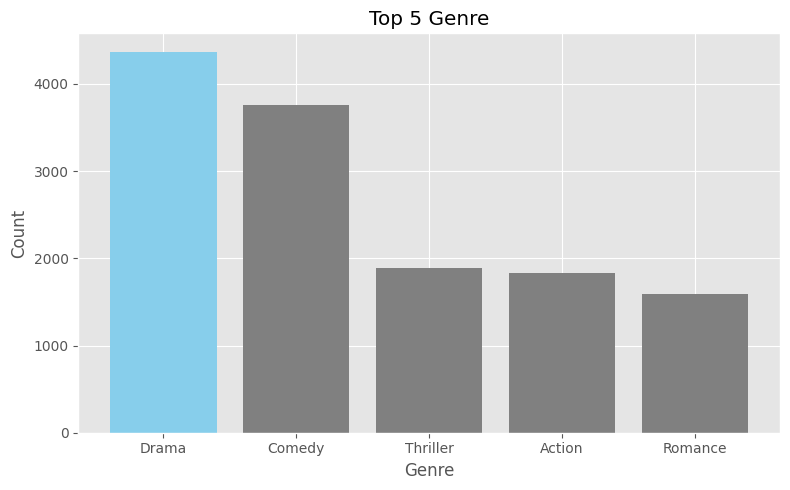

In [ ]:
genres_split = movies.genres.str.split('|').explode()
genre_counts = genres_split.value_counts().head(5)
colors = ['skyblue' if count == genre_counts.max() else 'gray' for count in genre_counts]
plt.figure(figsize=(8, 5))
bars = plt.bar(genre_counts.index, genre_counts.values, color=colors)
plt.title('Top 5 Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Insight**:

* Top 5 genre yang tercatat adalah drama, comedy, thriller, action, dan romance. Di mana kategori drama mendominasi sebanyak lebih dari 4000 data, lalu diikuti comedy yang tercatat melebihi 3000, lalu diikuti dengan genre thriller yang tercatat hampir sebanyak 2000 data.

#### Memvisualisasikan genre wordcloud

In [ ]:
def wordcloud(data, title):
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

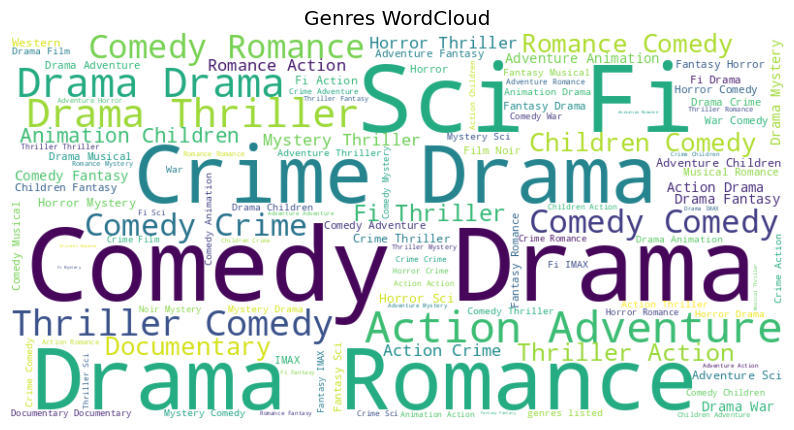

In [ ]:
wordcloud(genres_split, 'Genres WordCloud')

**Insight**:

* Wordcloud menyajikan kata (genre) dengan ukuran yang proporsional terhadap frekuensi kemunculannya, sehingga secara visual mudah mengidentifikasi genre mana yang dominan dan mana yang jarang muncul, seperti genre drama, comedy sering muncul dan genre action jarang muncul.

### ratings variable

#### Melakukan pengecekan tipe data dan banyak kolom

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


**Insight**:

* Berdasarkan hasil pengecekan maka dapat diketahui movieId, userId, dan timestamp bertipe int64, lalu rating bertipe float64. Serta tercatat terdapat 4 kolom dalam variabel ini.

#### Melakukan pengecekan 5 data pertama

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**Insight**:

* Dari 5 data pertama yang ditampilkan terlihat bahwa satu user mampu menonton dan memberikan rating lebih dari 1 film.

#### Melakukan pengecekan macam-macam rating dan jumlahnya

In [ ]:
print('Tipe rating film:\n', ratings.rating.unique())
print('\nBanyak tipe rating film:\n', ratings.rating.nunique())

Tipe rating film:
 [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]

Banyak tipe rating film:
 10


**Insight**

* Tercatat rating film memiliki 10 macam tipe rating, yaitu: 4.0, 5.0, 3.0, 2.0, 1.0, 4.5, 3.5, 2.5, 0.5, dan 1.5.

#### Melihat summary statistics

In [ ]:
ratings.describe(include='all')

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


**Insights**:

* Terdapat 100836 data dalam userId, dengan nilai minimal 1 dan maksimal 610.
* Terdapat 100836 data dalam movieId, dengan nilai minimal 1 dan max 193609.
* Terdapat 100836 data dalam rating, dengan nilai minimal 0.5 dan max 5.
* Terdapat 100836 data dalam timestamp, timestamp masih belum dalam format yang benar dan perlu diubah.

#### Melakukan pengecekan missing values dan duplikat

In [ ]:
ratings.isna().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


In [ ]:
ratings.duplicated().sum()

np.int64(0)

**Insight**:

* Tidak terdapat missing values dan duplikat yang tercatat.

#### Memvisualisasikan distribusi rating pengguna

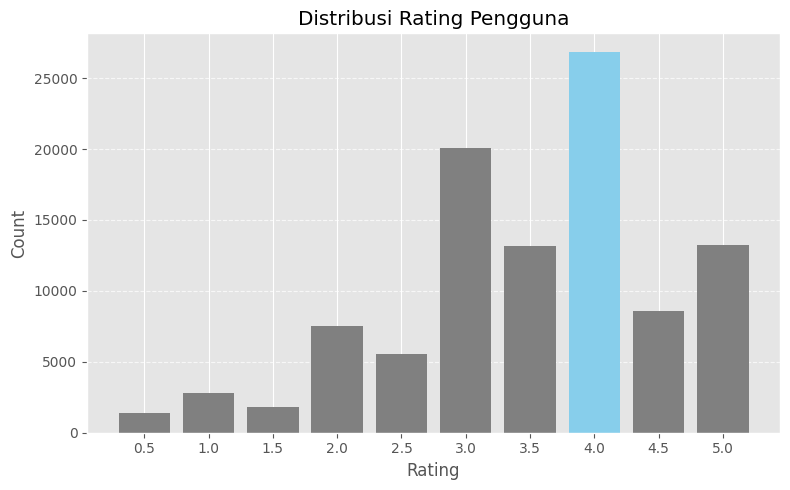

In [ ]:
rating_counts = ratings['rating'].value_counts().sort_index()
colors = ['skyblue' if count == rating_counts.max() else 'gray' for count in rating_counts]
plt.figure(figsize=(8, 5))
plt.bar(rating_counts.index.astype(str), rating_counts.values, color=colors)
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insight**:

* Visualisasi distribusi rating dengan barchart menunjukkan bagaimana pengguna memberikan penilaian terhadap film, dari skala 0.5 hingga 5.0. Dari grafik ini, kita bisa melihat kecenderungan bahwa pengguna lebih sering memberi rating tinggi seperti 3.0, 4.0, dan 5.0 dibanding rating rendah. Hal ini menunjukkan kualitas konten yang disukai pengguna relatif tinggi.

### tags variable

#### Melakukan pengecekan tipe data dan banyak kolom

In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


**Insight**:

* Berdasarkan hasil pengecekan maka dapat diketahui movieId, userId, dan timestamp bertipe data int64, tag bertipe object. Serta tercatat terdapat 4 kolom dalam variabel ini.

#### Melakukan pengecekan 5 data pertama

In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


**Insight**:

* Dari 5 bari pertama, tidak terlihat adanya duplikat values atau data.

#### Melakukan pengecekan macam-macam tag film dan jumlahnya

In [ ]:
print('Tipe tags film:\n', tags.tag.unique())
print('\nBanyaknya tipe tags film:\n', tags.tag.nunique())

Tipe tags film:
 ['funny' 'Highly quotable' 'will ferrell' ... 'gun fu' 'heroic bloodshed'
 'Heroic Bloodshed']

Banyaknya tipe tags film:
 1589


**Insight**:

* Terdapat 1589 unique tags yang tercatat, seperti funny, gun fu, dan will ferrell.

#### Melihat summary statistics

In [ ]:
tags.describe(include='all')

,userId,movieId,tag,timestamp
count,3683.000000,3683.000000,3683,3.683000e+03
unique,NaN,NaN,1589,NaN
top,NaN,NaN,In Netflix queue,NaN
freq,NaN,NaN,131,NaN
mean,431.149335,27252.013576,NaN,1.320032e+09
std,158.472553,43490.558803,NaN,1.721025e+08
min,2.000000,1.000000,NaN,1.137179e+09
25%,424.000000,1262.500000,NaN,1.137521e+09
50%,474.000000,4454.000000,NaN,1.269833e+09
75%,477.000000,39263.000000,NaN,1.498457e+09


**Insights**:

* Terdapat 3683 data userId yang tercatat, dengan userId terkecil 2 dan terbesar 610.
* Terdapat 3683 data movieId yang tercatat, dengan nilai terkecil 1 dan max 193565.
* Terdapat 3683 data tag yang tercatat, dengan nilai unique 1589.
* Terdapat 3683 data timestamp yang tercatat, tetapi formatnya masih salah.

#### Melakukan pengecekan missing values dan duplikat

In [ ]:
tags.isna().sum()

,0
userId,0
movieId,0
tag,0
timestamp,0


In [ ]:
tags.duplicated().sum()

np.int64(0)

**Insight**:

* Tidak terdapat missing values maupun data duplikat yang tercatat.

#### Memvisualisasikan tags wordcloud

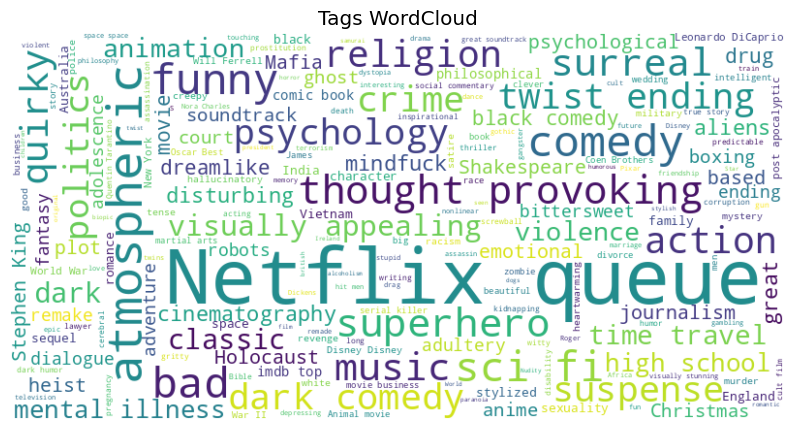

In [ ]:
wordcloud(tags.tag, 'Tags WordCloud')

**Insight**:

* Visualisasi tags wordcloud memberikan gambaran tentang istilah atau kata kunci yang sering digunakan oleh pengguna dalam memberikan tag ke film. Ini memperlihatkan minat atau asosiasi populer yang dimiliki pengguna terhadap film tertentu, misalnya “Netflix”, “thriller”, atau “classic”.

#### Memvisualisasikan top 5 tag

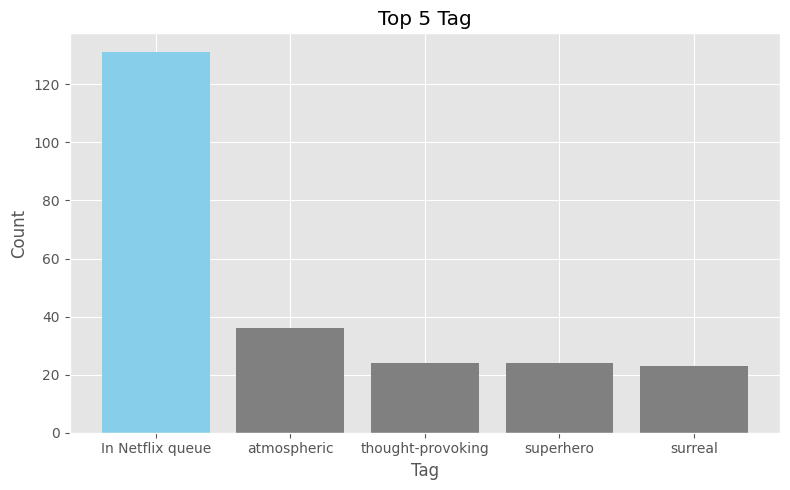

In [ ]:
tag_counts = tags.tag.value_counts().head(5)
colors = ['skyblue' if count == tag_counts.max() else 'gray' for count in tag_counts]
plt.figure(figsize=(8, 5))
bars = plt.bar(tag_counts.index, tag_counts.values, color=colors)
plt.title('Top 5 Tag')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Insight**:

* top 5 tags dalam bentuk barchart menunjukkan tag spesifik yang paling sering digunakan pengguna, yaitu "In Netflix Queue", "atmospheric". Berbeda dari wordcloud yang bersifat eksploratif, barchart memberikan informasi kuantitatif yang lebih jelas dan terukur.

### links variable

#### Melakukan pengecekan tipe data dan banyak kolom

In [ ]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


**Insight**:

* Berdasarkan hasil pengecekan maka dapat diketahui movieId dan imdbId bertipe data int64, tmdbId bertipe float64. Serta tercatat terdapat 3 kolom dalam variabel ini.

#### Melakukan pengecekan 5 data pertama

In [ ]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


**Insight**:

* Dari 5 data pertama yang terlihat, tidak terdapat duplikat values.

#### Melihat summary statistics

In [ ]:
links.describe(include='all')

,movieId,imdbId,tmdbId
count,9742.000000,9.742000e+03,9734.000000
mean,42200.353623,6.771839e+05,55162.123793
std,52160.494854,1.107228e+06,93653.481487
min,1.000000,4.170000e+02,2.000000
25%,3248.250000,9.518075e+04,9665.500000
50%,7300.000000,1.672605e+05,16529.000000
75%,76232.000000,8.055685e+05,44205.750000
max,193609.000000,8.391976e+06,525662.000000


**Insight**:

* Terdapat movieId yang tercatat sebanyak 9742 data, dengan nilai minimal 1 dan max 193609.
* Terdapat imdbId yang tercatat sebanyak 9742.
* Terdapat tmdbId yang tercatat sebanyak 9734.

#### Melakukan pengecekan missing values dan duplikat

In [ ]:
links.isna().sum()

,0
movieId,0
imdbId,0
tmdbId,8


In [ ]:
links.duplicated().sum()

np.int64(0)

**Insight**:

* Terdapat missing values dalam data tmdbId sebanyak 8 dan tidak terdapat duplikat value yang tercatat.

### visualization of movie ids and the num of users voted

In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

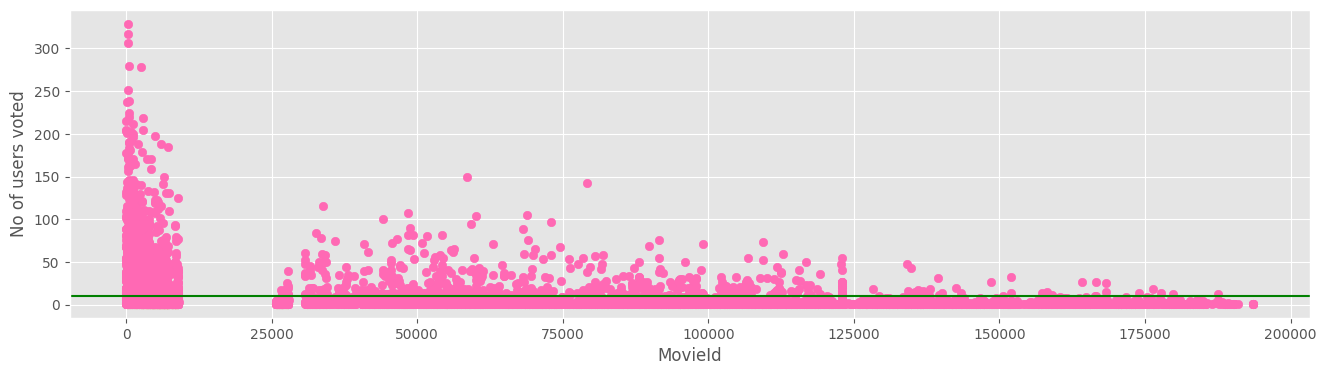

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
plt.scatter(no_user_voted.index, no_user_voted, color='hotpink')
plt.axhline(y=10, color='green')
plt.xlabel('MovieId')
plt.ylabel('No of users voted')
plt.show()

**Insight**:

* Visualisasi jumlah user yang memberikan rating terhadap setiap movie ID (movie\_ids vs. users voted) memperlihatkan id film mana yang paling sering dinilai oleh pengguna. Ini membantu mengidentifikasi film populer, yang bisa menjadi titik awal dalam sistem rekomendasi kolaboratif. Kemudian, jika film tertentu memiliki jumlah rating yang jauh lebih rendah, mungkin perlu dilakukan eksposur tambahan atau evaluasi terhadap relevansinya dengan audiens.

# Data Preparation

## Convert data type

In [ ]:
tags.timestamp = pd.to_datetime(tags.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')

## Make title to be lowercase

In [ ]:
movies['title'] = movies.title.str.lower()

## Clean year of the movie from titles

In [ ]:
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
movies['title'] = movies['title'].str.replace(r'\(\d{4}(–\d{4})?\)', '', regex=True).str.strip()

## Clean genres from separator -> `|`

In [ ]:
movies['genres'] = movies['genres'].str.replace(r"[\[\]']", "", regex=True).str.replace("|", " ")

## Concate title and genre

In [ ]:
movies['title_genre'] = movies['title'] + ' ' + movies['genres']

## Drop duplicates and null values if it's exist in choosen variable for modeling

In this case, i use movies and ratings variable.

In [ ]:
# movies
if movies.isna().sum().any():
    print('Ditemukan nilai null, menghapus baris yang mengandung null...')
    movies.dropna(inplace=True)

if movies.duplicated().any():
    print('Ditemukan data duplikat, menghapus duplikat...')
    movies.drop_duplicates(inplace=True)

# ratings
if ratings.isna().sum().any():
    print('Ditemukan nilai null, menghapus baris yang mengandung null...')
    ratings.dropna(inplace=True)

if ratings.duplicated().any():
    print('Ditemukan data duplikat, menghapus duplikat...')
    ratings.drop_duplicates(inplace=True)

print('Data telah bersih dari null dan duplikat.')

Data telah bersih dari null dan duplikat.


## Vectorize title_genre

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['title_genre'])

## Encode user and item for collaborative filtering

In [ ]:
user_enc = LabelEncoder()
item_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'])
ratings['item'] = item_enc.fit_transform(ratings['movieId'])

## Split data for collaborative filtering

In [ ]:
train_df, test_df = train_test_split(ratings, test_size=0.4, random_state=42)

# Modeling

## Content Based Filtering

### Calculate cosine similarity

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

### Top-k recommendation

In [ ]:
indices = pd.Series(movies.index, index=movies['title'])
def content_based_recommendations(title, cosine_sim=cosine_sim):
    title = title.lower()
    idx = indices[title]

    sim_scores = cosine_sim[idx]
    if hasattr(sim_scores, "toarray"):  # untuk sparse matrix
        sim_scores = sim_scores.toarray().flatten()
    else:
        sim_scores = sim_scores.flatten()

    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    return movies[['title', 'genres']].iloc[movie_indices]

In [ ]:
content_based_recommendations('MONSTER')

,title,genres
4523,party monster,Comedy Crime Drama Thriller
3651,monster's ball,Drama Romance
9272,money monster,Drama Thriller
4978,monster in a box,Comedy Drama
5898,monster-in-law,Comedy Romance
3081,"monster squad, the",Adventure Comedy Horror
6250,monster house,Animation Children Fantasy Mystery
1955,"monster, the (mostro, il)",Comedy
5724,metallica: some kind of monster,Documentary
8143,yongary: monster from the deep,Children Horror Sci-Fi


In [ ]:
content_based_recommendations('toy story')

,title,genres
2355,toy story 2,Adventure Animation Children Comedy Fantasy
7355,toy story 3,Adventure Animation Children Comedy Fantasy IMAX
3595,"toy, the",Comedy
2539,we're back! a dinosaur's story,Adventure Animation Children Fantasy
2227,"story of us, the",Comedy Drama
4089,toy soldiers,Action Drama
7039,up,Adventure Animation Children Drama
1617,"neverending story, the",Adventure Children Fantasy
1570,l.a. story,Comedy Romance
6194,"wild, the",Adventure Animation Children Comedy Fantasy


In [ ]:
content_based_recommendations('iron SoldiEr')

,title,genres
1728,soldier,Action Sci-Fi War
6743,iron man,Action Adventure Sci-Fi
2114,universal soldier,Action Sci-Fi
8151,iron man 3,Action Sci-Fi Thriller IMAX
7855,iron sky,Action Comedy Sci-Fi
7324,iron man 2,Action Adventure Sci-Fi Thriller IMAX
3822,iron will,Adventure
2113,universal soldier: the return,Action Sci-Fi
2142,"soldier's story, a",Drama
9444,iron man,Drama


## Collaborative Filtering

### Build Interaction Matrices

In [ ]:
def build_interaction_matrix(df, user_col, item_col, rating_col, num_users, num_items):
    # use the total number of unique users and items from the original dataset
    # for the shape of the matrix.
    return coo_matrix(
        (df[rating_col], (df[user_col], df[item_col])),
        shape=(num_users, num_items)
    )

# get the total number of unique users and items from the fitted encoders
num_total_users = len(user_enc.classes_)
num_total_items = len(item_enc.classes_)

# build the interaction matrices using the total number of users and items
train_interaction = build_interaction_matrix(train_df, 'user', 'item', 'rating', num_total_users, num_total_items)
test_interaction = build_interaction_matrix(test_df, 'user', 'item', 'rating', num_total_users, num_total_items)

In [ ]:
model = LightFM(loss='warp')
model.fit(train_interaction, epochs=50, num_threads=2)

### Top-k recommendation

In [ ]:
def recommend_items(model, interaction_matrix, user_id, item_labels, movies_df, n=3):
    """
    Memberikan rekomendasi top-N item untuk user tertentu menggunakan model collaborative filtering.

    Parameters:
    - model: LightFM trained model
    - interaction_matrix: sparse matrix interaksi user-item
    - user_id: index user yang ingin diberi rekomendasi (bukan original userId, tapi hasil encoding)
    - item_labels: LabelEncoder untuk item/movieId
    - movies_df: DataFrame yang berisi movieId dan title
    - n: jumlah rekomendasi yang ingin ditampilkan

    Returns:
    - List judul film yang direkomendasikan
    """

    n_items = interaction_matrix.shape[1]
    scores = model.predict(user_id, np.arange(n_items))  # prediction score for all items
    top_items = np.argsort(-scores)[:n]  # take highest score

    recommendation_results = []
    for i in top_items:
        movie_id = item_labels.inverse_transform([i])[0]  # take the movieId
        movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        recommendation_results.append(movie_title)
    return recommendation_results

In [ ]:
print(f'Top 10 recommendations for User Index 2:\n')
movies_titles = recommend_items(model, train_interaction, user_id=2, item_labels=item_enc, movies_df=movies, n=10)
for i in range(len(movies_titles)):
  print(movies_titles[i])

Top 10 recommendations for User Index 2:

lion king, the
aladdin
independence day (a.k.a. id4)
mask, the
apollo 13
star wars: episode iv - a new hope
beauty and the beast
toy story
silence of the lambs, the
forrest gump


In [ ]:
print(f'Top 10 recommendations for User Index 5:\n')
movies_titles = recommend_items(model, train_interaction, user_id=5, item_labels=item_enc, movies_df=movies, n=10)
for i in range(len(movies_titles)):
  print(movies_titles[i])

Top 10 recommendations for User Index 5:

sudden death
heavy metal
waterworld
don juan demarco
cliffhanger
outbreak
fugitive, the
sabrina
clear and present danger
birdcage, the


# Evaluation

## Evaluate content based filtering

In [ ]:
def precision_recall_content_based(input_movie, recommended_movies, k=10):
    input_movie = input_movie.lower()
    input_tfidf = tfidf.transform([input_movie])
    rec_tfidf = tfidf.transform(recommended_movies)

    # calculate cosine similarity between input and recommendations
    sim_scores = cosine_similarity(input_tfidf, rec_tfidf)[0]

    # precision and recall
    precision = sum(sim_scores[:k]) / k
    recall = sum(sim_scores[:k]) / sum(sim_scores) if sum(sim_scores) > 0 else 0
    return precision, recall

In [ ]:
input_movies = ['toy story', 'grumpier old men']
recommendation_results = {movie: list(content_based_recommendations(movie)['title']) for movie in input_movies}
for movie in input_movies:
    recommended_titles = recommendation_results[movie]
    precision, recall = precision_recall_content_based(movie, recommended_titles)
    print(f"Precision@10 for '{movie}': {precision:.2f}")
    print(f"Recall@10 for '{movie}': {recall:.2f}")

Precision@10 for 'toy story': 0.52
Recall@10 for 'toy story': 1.00
Precision@10 for 'grumpier old men': 0.43
Recall@10 for 'grumpier old men': 1.00


## Evaluate collaborative based filtering

In [ ]:
train_precision = precision_at_k(model, train_interaction, k=10).mean()
test_precision = precision_at_k(model, test_interaction, k=10).mean()
train_auc = auc_score(model, train_interaction).mean()
test_auc = auc_score(model, test_interaction).mean()
print(f"Train Precision@10: {train_precision:.4f}")
print(f"Test Precision@10: {test_precision:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Train Precision@10: 0.3618
Test Precision@10: 0.1679
Train AUC: 0.9694
Test AUC: 0.9170
